<a href="https://colab.research.google.com/github/0o0liver/Going_Back_to_Work/blob/master/Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demand model prediction

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import glob, os 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import metrics
from datetime import datetime, timedelta
from functools import partial
from IPython.core.debugger import set_trace
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2010.csv
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2011.csv
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2012.csv
!wget -q https://raw.githubusercontent.com/0o0liver/Going_Back_to_Work/master/datasets/resultant_data/dropoff_200_west_street_nyc_2013.csv

In [0]:
all_files = glob.glob(os.path.join('/content', "*.csv"))
df = pd.concat((pd.read_csv(f, parse_dates=[0], index_col=0, usecols=[0], date_parser=pd.to_datetime) for f in all_files))

In [0]:
df_copy = df.copy()
df_copy['count'] = 1.
df_copy = df_copy.resample("30min").sum()
df_copy = df_copy.loc[:'2013-05-01'] # filter out last days of december 

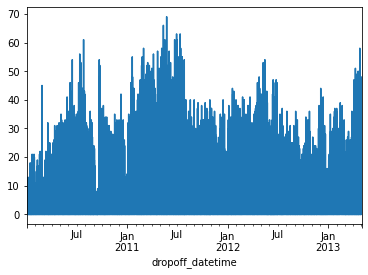

In [6]:
df_copy['count'].plot()

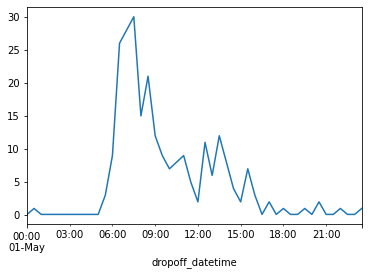

In [7]:
s = df_copy['count']
X = s.where(s > 0, 0.1) # cannot have 0 values for holt-winters
size = int(len(X)-48) # 2 periods per hour, 24 hours per day = 48 periods per day
train, test = X[0:size], X[size:len(X)]
test.plot()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


Test MSE: 15.279


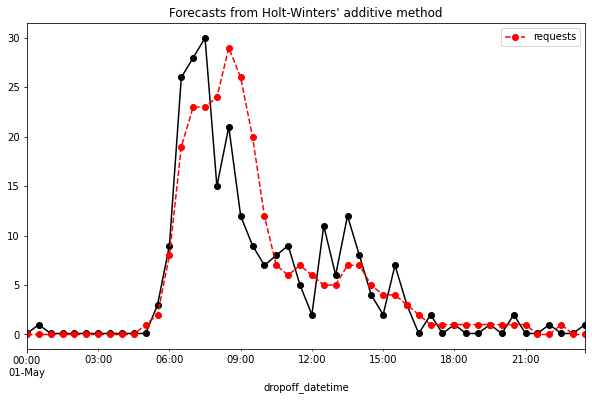

Figure 1


In [8]:
fit1 = sm.tsa.ExponentialSmoothing(train, seasonal_periods=336, trend='add', seasonal='add').fit(use_boxcox=True)

results=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_slope', 'damping_slope', 'smoothing_seasonal', 'initial_level', 'initial_slope']
results["Additive"]       = [fit1.params[p] for p in params] + [fit1.sse]

ax = test.plot(figsize=(10,6), marker='o', color='black', title="Forecasts from Holt-Winters' additive method" )

yhat = fit1.forecast(len(X)-size).rename('requests').round()

error = metrics.mean_squared_error(test.values.ravel(), yhat.values.ravel())
print('Test MSE: %.3f' % error)

yhat.plot(ax=ax, style='--', marker='o', color='red', legend=True)

plt.show()
print("Figure 1")

# Helper Functions

A helper function to generate duration length (which was not present in our data)

In [0]:
from scipy.stats import poisson
# setup poisson number generator
mu=6
rv = poisson(mu, loc=1)

# Generates a duration selecting from poisson distribution
def generate_duration(demand, shuffle = True, remove_zeroes = True):
  requests = []
  for index, value in demand.items():
    if not remove_zeroes and int(value) == 0:
      d = {
          'datetime' : index,
          'duration' : 0
      }
      requests.append(d)
    for _ in range(int(value)):
      d = {
          'datetime' : index,
          'duration' : rv.rvs()
      }
      requests.append(d)

  requests_df = pd.DataFrame(requests)
  if shuffle: requests_df = requests_df.sample(frac=1)
  return requests_df

# Prioritized Planner

In [0]:
class prioritized_planner:
  def __init__(self, demand_model, threshold):
    '''
    demand_model: np.Serise(timestamp, float)
    threshold: safety threshold for the building, int type.
    '''
    self.demand_model = dict()
    self.current_occupation = dict()
    for i, row in demand_model.iterrows():
      self.demand_model[str(row["datetime"]).split(" ")[-1]] = int(row["duration"])
      self.current_occupation[str(row["datetime"]).split(" ")[-1]] = 0
    self.threshold = threshold 
    self.key_lst = list(self.current_occupation.keys())
    self.total_request = 0
    self.approved_request = 0

  def approval_rate(self):
    return self.approved_request / self.total_request

  def utilization(self):
    area_accumulator = 0
    for v in self.current_occupation.values():
      area_accumulator += v
    return area_accumulator / (len(self.current_occupation)*self.threshold)

  def show_demand(self):
    '''
    Print demand model
    '''
    print("Building demand model:")
    plt.bar(self.demand_model.keys(), self.demand_model.values())
    plt.show()

  def show_current(self):
    '''
    Print current state
    '''
    print("Safety threshold:", self.threshold)
    print("Building current state:")
    lists = sorted(self.current_occupation.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.bar(x, y)
    plt.show()

  def add_occupant(self, arrival_time, len_of_stay):
    '''
    Update the current state of the building.
    '''
    arrival_time_index = self.key_lst.index(arrival_time)
    request_time_slot = self.key_lst[arrival_time_index:arrival_time_index+len_of_stay]
    for key in request_time_slot:
      self.current_occupation[key] += 1

  def check_availability(self, arrival_time, len_of_stay):
    '''
    arrival_time: hh:mm:ss
    len_of_stay: number of 30 min block, len_of_stay = 2 would mean that requester wants to stay for one hour.
    '''
    arrival_time_index = self.key_lst.index(arrival_time)
    request_time_slot = self.key_lst[arrival_time_index:arrival_time_index+len_of_stay]
    for key in request_time_slot:
      if self.current_occupation[key] >= self.threshold:
        return False
    return True
  
  def check_priority(self, arrival_time, len_of_stay):
    '''
    Determine if a request should be approved accoriding to priority.
    The goal is to fit as many people as possible. 
    '''
    if len_of_stay <= 2:
      return True
    count = 0
    arrival_time_index = self.key_lst.index(arrival_time)
    request_time_slot = self.key_lst[arrival_time_index+1:arrival_time_index+len_of_stay]
    for key in request_time_slot:
      if self.threshold - self.current_occupation[key] == 1 and self.demand_model[key] >= self.threshold:
        count += 1
    if count > 1:
      return False
    return True 

  def request(self, arrival_time, len_of_stay):
    '''
    arrival_time: hh:mm:ss
    len_of_stay: number of 30 min block, len_of_stay = 2 would mean that requester wants to stay for one hour.
    '''
    try:
      self.total_request += 1
      if not self.check_availability(arrival_time, len_of_stay):
        return
      if not self.check_priority(arrival_time, len_of_stay):
        return
      self.approved_request += 1
      self.add_occupant(arrival_time, len_of_stay)
      return 
    except ValueError:
      return 


# First Come First Serve

In [0]:
class fcfs:
  def __init__(self, demand_model, threshold):
    '''
    demand_model: np.Serise(timestamp, float)
    threshold: safety threshold for the building, int type.
    '''
    self.demand_model = demand_model
    self.current_occupation = {k:0 for k in demand_model['datetime']}
    self.threshold = threshold 
    self.approved_requests = 0
    self.total_requests = 0

  def approval_rate(self):
    return self.approved_requests / self.total_requests

  def utilization(self):
    area_accumulator = 0
    for v in self.current_occupation.values():
      area_accumulator += v
    return area_accumulator / (len(self.current_occupation)*self.threshold)

  def show_current(self):
    '''
    Print current state
    '''
    print("Safety threshold:", self.threshold)
    print("Building current state:")
    lists = sorted(self.current_occupation.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.bar(x, y)
    plt.show()

  def add_occupant(self, arrival_time, len_of_stay):
    '''
    Update the current state of the building.
    '''
    for _ in range(len_of_stay):
      if arrival_time not in self.current_occupation: self.current_occupation[time] = 0
      self.current_occupation[arrival_time] += 1
      arrival_time = arrival_time + timedelta(minutes=30)

  def check_availability(self, arrival_time, len_of_stay):
    '''
    arrival_time: hh:mm:ss
    len_of_stay: number of 30 min block, len_of_stay = 2 would mean that requester wants to stay for one hour.
    '''
    for _ in range(len_of_stay):
      if arrival_time not in self.current_occupation: self.current_occupation[arrival_time] = 0
      if self.current_occupation[arrival_time] >= self.threshold:
        return False
      arrival_time = arrival_time + timedelta(minutes=30)
    return True

  def request(self, arrival_time, len_of_stay):
    '''
    arrival_time: hh:mm:ss
    len_of_stay: number of 30 min block, len_of_stay = 2 would mean that requester wants to stay for one hour.
    '''
    try:
      self.total_requests += 1
      if not self.check_availability(arrival_time, len_of_stay):
        self.approved_requests += 1
        return True
      self.add_occupant(arrival_time, len_of_stay)
      return False
    except ValueError:
      print("Please format arrival_time correctly.")
      return False


# Greedy Local Search

In [0]:
class greedy:
  def __init__(self, demand_model, threshold):
    '''
    demand_model: pandas dataframe (int, timestamp, float) in sorted order
    threshold: safety threshold for the building, int type.
    '''
    self.demand_model = demand_model
    self.optimal_appointments = self.hill_climb(demand_model, threshold)
    self.optimal_appointments_mutable = self.optimal_appointments.copy()
    self.current_occupation = {k:0 for k in demand_model['datetime']}
    self.threshold = threshold 
    self.total_requests = 0.
    self.approved_requests = 0.

  def approval_rate(self):
    return self.approved_requests / self.total_requests

  def utilization(self):
    area_accumulator = 0
    for v in self.current_occupation.values():
      area_accumulator += v
    return area_accumulator / (len(self.current_occupation)*self.threshold)

  def calculate_occupancy(self, appointments):
    occupancy={}
    for i,row in appointments.iterrows():
      time = row['datetime']
      for _ in range(row['duration']):
        if time not in occupancy: occupancy[time] = []
        occupancy[time].append(i)
        time = time + timedelta(minutes=30)
    return occupancy

  def hill_climb(self, demand_model, threshold):
    # construct a mapping from time block to all appointments that want to use
    # that time block
    occupancy = self.calculate_occupancy(demand_model)

    # Trim our appointments. First assign a value to each appointment =
    # number of blocks - number of blocks that are over the threshold
    appointments = demand_model.copy()
    appointments['value'] = 0
    while True:
      lowest_value = 0
      lowest_negative_value_idx = -1
      for i,row in appointments.iterrows():
        time = row['datetime']
        cost_accumulator = 0
        for _ in range(row['duration']):
          cost = threshold - len(occupancy[time]) - 1
          if cost < 0: cost_accumulator += cost
        value = row['duration'] + cost_accumulator
        appointments.at[i, 'value'] = value # this line doesn't work...
        if value < lowest_value:
          lowest_value = value
          if value < 0: lowest_negative_value_idx = i

      # Remove the appointment with the minimum value and update occupancy
      if lowest_negative_value_idx >= 0:
        row = appointments.loc[lowest_negative_value_idx]
        time = row['datetime']
        for _ in range(row['duration']):
          occupancy[time].remove(lowest_negative_value_idx)
          time = time + timedelta(minutes=30)
        appointments = appointments.drop(lowest_negative_value_idx)
      else:
        break

    return appointments

  def show_demand(self):
    '''
    Print demand model
    '''
    print("Building demand model:")
    demand_model.drop('duration').groupby('datetime').sum().plot(ax=ax, style='--', marker='o', color='red', legend=True)

  def show_optimal_occupancy(self):
    occupancy = calculate_occupancy(demand_model)
    # plot
    lists = sorted(occupancy.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    y = [len(row) for row in y]
    plt.bar(x, y)
    plt.show()

  def show_current(self):
    '''
    Print current state
    '''
    print("Safety threshold:", self.threshold)
    print("Building current state:")
    lists = sorted(self.current_occupation.items()) # sorted by key, return a list of tuples
    x, y = zip(*lists) # unpack a list of pairs into two tuples
    plt.bar(x, y)
    plt.show()

  def add_occupant(self, arrival_time, len_of_stay):
    '''
    Update the current state of the building.
    '''
    for _ in range(len_of_stay):
      if arrival_time not in self.current_occupation: self.current_occupation[arriaval_time] = 0
      self.current_occupation[arrival_time] += 1
      arrival_time = arrival_time + timedelta(minutes=30)

  def check_availability(self, arrival_time, len_of_stay):
    '''
    arrival_time: hh:mm:ss
    len_of_stay: number of 30 min block, len_of_stay = 2 would mean that requester wants to stay for one hour.
    '''
    for _ in range(len_of_stay):
      if arrival_time not in self.current_occupation: self.current_occupation[arrival_time] = 0
      if self.current_occupation[arrival_time] >= self.threshold:
        return False
      arrival_time = arrival_time + timedelta(minutes=30)
    return True
  
  def check_priority(self, arrival_time, len_of_stay):
    '''
    Determine if a request should be approved accoriding to priority.
    Our policy is if the request is on our optimal schedule, then we approve
    If it is longer than any thing in our optimal  
    '''
    appointment = self.optimal_appointments_mutable[(self.optimal_appointments_mutable['datetime']==arrival_time) & (self.optimal_appointments_mutable['duration']==len_of_stay)]
    # if there is an appointment in our optimal that matches, use it
    if appointment.shape[0] > 0:
      self.optimal_appointments_mutable.drop(appointment.head(1).index)
      return True
    else:
      # if its not in our optimal appointments, we still want to check if we can fit it
      reserved_occupancy = self.calculate_occupancy(self.optimal_appointments_mutable)
      fits = False
      for _ in range(len_of_stay):
        if arrival_time not in reserved_occupancy: reserved_occupancy[arrival_time] = [-1]
        if arrival_time not in self.current_occupation: self.current_occupation[arrival_time] = 0
        if len(reserved_occupancy[arrival_time]) + self.current_occupation[arrival_time] <= self.threshold: fits = True
        else: 
          fits = False
          break
        arrival_time = arrival_time + timedelta(minutes=30)
    # otherwise reject it
    return fits

  def request(self, arrival_time, len_of_stay):
    '''
    arrival_time: hh:mm:ss
    len_of_stay: number of 30 min block, len_of_stay = 2 would mean that requester wants to stay for one hour.
    '''
    try:
      self.total_requests += 1
      if not self.check_priority(arrival_time, len_of_stay):
        return False
      if not self.check_availability(arrival_time, len_of_stay):
        return True
      self.approved_requests += 1
      self.add_occupant(arrival_time, len_of_stay)
      return True
    except ValueError:
      print("Please format arrival_time correctly.")
      return False


# Drive our planners

Generate our data with a length of stay

In [0]:
predicted = generate_duration(yhat, False, False)
requests_df = generate_duration(test)

Plot our requests accepting all

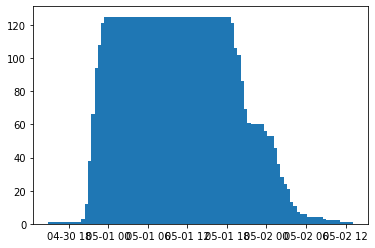

In [14]:
temp_occupancy = {k:0 for k in requests_df['datetime']}
for i, row in requests_df.iterrows():
  arrival_time = row['datetime']
  for _ in range(row['duration']):
    if arrival_time not in temp_occupancy: temp_occupancy[arrival_time] = 0
    temp_occupancy[arrival_time] += 1
    arrival_time = arrival_time + timedelta(minutes=30)

# Plot
lists = sorted(temp_occupancy.items()) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples
plt.bar(x, y)
plt.show()

Utilization: 0.5034722222222222
Approval Rate: 0.44715447154471544
Safety threshold: 30
Building current state:


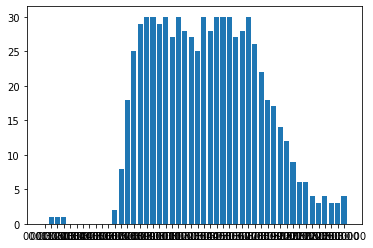

In [41]:
PP = prioritized_planner(predicted, 30)

for i, row in requests_df.iterrows():
  approved = PP.request(str(row['datetime']).split(" ")[-1], row['duration'])

print("Utilization:", PP.utilization())
print("Approval Rate:", PP.approval_rate())
PP.show_current()

Utilization: 0.27355769230769234
Approval Rate: 0.3780487804878049
Safety threshold: 40
Building current state:


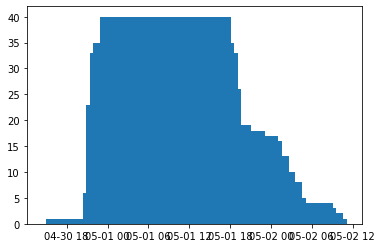

In [33]:
Greedy = greedy(predicted, 40)

total_count = 0
approved_count = 0
for i, row in requests_df.iterrows():
  approved = Greedy.request(row['datetime'], row['duration'])

# Print results
print("Utilization:", Greedy.utilization())
print("Approval Rate:", Greedy.approval_rate())
Greedy.show_current()

Utilization: 0.43365384615384617
Approval Rate: 0.44715447154471544
Safety threshold: 40
Building current state:


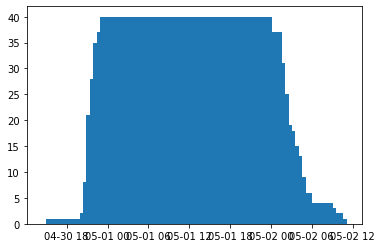

In [40]:
Fcfs = fcfs(predicted, 40)

for i, row in requests_df.iterrows():
  Fcfs.request(row['datetime'], row['duration'])

# Print results
print("Utilization:", Fcfs.utilization())
print("Approval Rate:", Fcfs.approval_rate())
Fcfs.show_current()

# Scratch Code

In [0]:
#from collections import OrderedDict 

def hill_climb_test(demand_model, threshold):
  # construct a mapping from time block to all appointments that want to use
  # that time block
  #occupancy=OrderedDict() 
  occupancy={}
  appointments = demand_model.copy()
  appointments['value'] = 0
  for i,row in appointments.iterrows():
    #time = row['datetime'].time()
    time = row['datetime']
    for _ in range(row['duration']):
      if time not in occupancy: occupancy[time] = []
      occupancy[time].append(i)
      time = time + timedelta(minutes=30)

  # Trim our appointments. First assign a value to each appointment =
  # number of blocks - number of blocks that are over the threshold
  
  while True:
    lowest_value = 0
    lowest_negative_value_idx = -1
    for i,row in appointments.iterrows():
      time = row['datetime']
      cost_accumulator = 0
      for _ in range(row['duration']):
        cost = threshold - len(occupancy[time]) - 1
        if cost < 0: cost_accumulator += cost
      value = row['duration'] + cost_accumulator
      appointments.at[i, 'value'] = value # this line doesn't work...
      if value < lowest_value:
        lowest_value = value
        if value < 0: lowest_negative_value_idx = i

    # Remove the appointment with the minimum value and update occupancy
    if lowest_negative_value_idx >= 0:
      row = appointments.loc[lowest_negative_value_idx]
      time = row['datetime']
      for _ in range(row['duration']):
        occupancy[time].remove(lowest_negative_value_idx)
        time = time + timedelta(minutes=30)
      appointments = appointments.drop(lowest_negative_value_idx)
    else:
      break

  # plot
  lists = sorted(occupancy.items()) # sorted by key, return a list of tuples
  x, y = zip(*lists) # unpack a list of pairs into two tuples
  y = [len(row) for row in y]
  print('x',x)
  print('y',y)
  plt.bar(x, y)
  plt.show()
  return appointments

In [0]:
temp = generate_duration(test, False, False)
# Test our hill climb
hill_climb_test(temp, 15)

# Compare to FCFS
Fcfs = fcfs(yhat, 15)
shuffled_temp = temp.sample(frac=1)
for i, row in shuffled_temp.iterrows():
  Fcfs.request(str(row['datetime'].time()), row['duration'])
Fcfs.show_current()

In [0]:
temp_df = pd.DataFrame([[0, 2, 3], [0, 4, 1], [10, 20, 30]], columns=['A', 'B', 'C'])

In [0]:
temp_df = temp_df.drop(1)

In [0]:
for i,v in temp_df.iterrows():
  print(i)